## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import lightgbm as lgb
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/Train.csv"
predict_dataset = "Dataset/Test.csv"

## Data Preprocessing

### Read train and predict datasets

In [3]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (1358, 16)
predict_df: (583, 15)


### Extract "class" field from train_df into NumPy array

In [4]:
train_df['class_enc'] = train_df['class'].apply(lambda x: 0 if x == 1 else 1)
train_y = np.array([train_df['class_enc'].values]).T
train_df.drop(['class', 'class_enc'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (1358, 1)


### Combine train and predict dataframes

In [5]:
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
combined_df.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0


### Feature Engineering

#### Box-cox Transformation

In [6]:
_, opt_lambda = boxcox(combined_df['max_luminosity'])
combined_df['max_luminosity'] = boxcox(combined_df['max_luminosity'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['thickness'])
combined_df['thickness'] = boxcox(combined_df['thickness'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['xmin'] + 1e-10)
combined_df['xmin'] = boxcox(combined_df['xmin'] + 1e-10, lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['xmax'])
combined_df['xmax'] = boxcox(combined_df['xmax'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['ymin'] + 1e-10)
combined_df['ymin'] = boxcox(combined_df['ymin'] + 1e-10, lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['ymax'])
combined_df['ymax'] = boxcox(combined_df['ymax'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['pixel_area'])
combined_df['pixel_area'] = boxcox(combined_df['pixel_area'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df['log_area'])
combined_df['log_area'] = boxcox(combined_df['log_area'], lmbda=opt_lambda)

#### Create new features

In [7]:
x1 = np.min(combined_df['xmin'])
x2 = np.max(combined_df['xmin'])
x3 = np.min(combined_df['xmax'])
x4 = np.max(combined_df['xmax'])
combined_df['xmin_std'] = (combined_df['xmin'] - x1)/x2
combined_df['xmax_std'] = (combined_df['xmax'] - x3)/x4

In [8]:
y1 = np.min(combined_df['ymin'])
y2 = np.max(combined_df['ymin'])
y3 = np.min(combined_df['ymax'])
y4 = np.max(combined_df['ymax'])
combined_df['ymin_std'] = (combined_df['ymin'] - y1)/y2
combined_df['ymax_std'] = (combined_df['ymax'] - y3)/y4

In [9]:
l1 = np.min(combined_df['log_area'])
l2 = np.max(combined_df['log_area'])
p1 = np.min(combined_df['pixel_area'])
p2 = np.max(combined_df['pixel_area'])
combined_df['log_area_std'] = (combined_df['log_area'] - l1)/l2
combined_df['pixel_area_std'] = (combined_df['pixel_area'] - p1)/p2

In [10]:
combined_df['x_avg'] = (combined_df['xmin'] + combined_df['xmax'])/2
combined_df['y_avg'] = (combined_df['ymin'] + combined_df['ymax'])/2
combined_df['area_avg'] = (combined_df['pixel_area'] + combined_df['log_area'])/2
#combined_df.drop(['xmax','xmin','ymax','ymin','log_area','pixel_area'], axis = 1, inplace=True)

In [11]:
x_min = np.min(combined_df['x_avg'])
x_max = np.max(combined_df['x_avg'])
y_min = np.min(combined_df['y_avg'])
y_max = np.max(combined_df['y_avg'])
area_min = np.min(combined_df['area_avg'])
area_max = np.max(combined_df['area_avg'])
thick_min = np.min(combined_df['thickness'])
thick_max = np.max(combined_df['thickness'])

combined_df['xavg_std'] = (combined_df['x_avg'] - x_min)/x_max
combined_df['yavg_std'] = (combined_df['y_avg'] - y_min)/y_max
combined_df['area_std'] = (combined_df['area_avg'] - area_min)/area_max
combined_df['thickness_std'] = (combined_df['thickness'] - thick_min)/thick_max

In [12]:
combined_df['x_component_11'] = combined_df['x_component_1'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_22'] = combined_df['x_component_2'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_33'] = combined_df['x_component_3'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_44'] = combined_df['x_component_4'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df['x_component_55'] = combined_df['x_component_5'].mask(((combined_df['x_component_1']==0) & (combined_df['x_component_2']==0) & (combined_df['x_component_3']==0) & (combined_df['x_component_4']==0) & (combined_df['x_component_5']==0)), -1)
combined_df.drop(['x_component_1','x_component_2','x_component_3','x_component_4','x_component_5'], axis = 1, inplace=True)

In [13]:
combined_df['lumis/pa'] = combined_df['max_luminosity'] / combined_df['pixel_area']
combined_df['lumis/la'] = combined_df['max_luminosity'] / combined_df['log_area']
combined_df['lumis/ymin'] = combined_df['max_luminosity'] / combined_df['ymin']
combined_df['lumis/ymax'] = combined_df['max_luminosity'] / combined_df['ymax']
combined_df['x_diff'] = np.square(combined_df['xmax'] - combined_df['xmin'])
combined_df['y_diff'] = np.square(combined_df['ymax'] - combined_df['ymin'])
combined_df['area_ratio'] = combined_df['pixel_area']/combined_df['log_area']
combined_df['thick/pa'] = combined_df['thickness']/combined_df['pixel_area']
combined_df['thick/la'] = combined_df['thickness']/combined_df['log_area']

In [16]:
combined_df['xavg/yavg'] = combined_df['y_avg']/combined_df['x_avg']
combined_df['ymin/xmin'] = combined_df['ymin']/combined_df['xmin']
combined_df['ymax/xmax'] = combined_df['ymax']/combined_df['xmax']
combined_df['yarea/xarea'] = np.sqrt((combined_df['ymin'] * combined_df['ymax'])/((combined_df['xmin'] * combined_df['xmax'])+1e-10))

In [17]:
combined_df['pa/y'] = combined_df['pixel_area']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['pa/x'] = combined_df['pixel_area']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['la/y'] = combined_df['log_area']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['la/x'] = combined_df['log_area']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['ml/y'] = combined_df['max_luminosity']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['ml/x'] = combined_df['max_luminosity']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)
combined_df['t/y'] = combined_df['thickness']/np.sqrt((combined_df['ymin'] * combined_df['ymax'])+1e-10)
combined_df['t/x'] = combined_df['thickness']/np.sqrt((combined_df['xmin'] * combined_df['xmax'])+1e-10)

### Create train and predict Numpy arrays

In [18]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:1358].values
predict_x = combined_df[1358:].values

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (1358, 49)
predict_x: (583, 49)


In [19]:
train_x_full = train_x.copy()
train_y_full = train_y.copy()

### Split training data into train/test datasets

In [20]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.075, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (1256, 49)
train_y shape: (1256, 1)

------------------------- Test Dataset -------------------------
test_x shape: (102, 49)
test_y shape: (102, 1)


In [21]:
Xtrain_full, Ytrain_full = train_x_full.copy(), train_y_full.copy()
Xtrain, Ytrain = train_x.copy(), train_y.copy()
Xtest, Ytest = test_x.copy(), test_y.copy()
Xpredict = predict_x.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (1358, 49)
Ytrain_full shape: (1358, 1)
Xtrain shape: (1256, 49)
Ytrain shape: (1256, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (102, 49)
Ytest shape: (102, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (583, 49)


## Hyperparameter search using Optuna

In [22]:
# Convert Ytest to one-hot encoding
df = pd.DataFrame(Ytest, columns=["class"])
test_y = pd.get_dummies(df['class']).values

In [23]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [24]:
def objective(trial):
    
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 2,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "max_bin": trial.suggest_int("max_bin", 256, 512),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 35, 200),
        "max_depth": trial.suggest_int("max_depth", 8, 25),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20)
    }
    
    y_pred = 0
    counter = 0
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1
    
        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, valid_sets=[lgvalidation], 
                          num_boost_round=5000, early_stopping_rounds=200, verbose_eval=False)
        pred = model.predict(Xtest, num_iteration=model.best_iteration)

        y_pred += pred

    y_pred /= float(counter)
    loss = log_loss(test_y, y_pred)
    return loss

In [25]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

[I 2020-05-24 22:17:26,248] Finished trial#0 with value: 0.3199277250881466 with parameters: {'max_bin': 367, 'learning_rate': 0.041419036728021025, 'lambda_l2': 0.00019529087762552004, 'num_leaves': 188, 'max_depth': 13, 'feature_fraction': 0.8044609634012138, 'bagging_fraction': 0.5174007433576644, 'bagging_freq': 9, 'min_child_samples': 6}. Best is trial#0 with value: 0.3199277250881466.
[I 2020-05-24 22:18:07,936] Finished trial#1 with value: 0.32451398345241866 with parameters: {'max_bin': 268, 'learning_rate': 0.011040661066110489, 'lambda_l2': 0.46736565408354896, 'num_leaves': 173, 'max_depth': 24, 'feature_fraction': 0.5447199144737045, 'bagging_fraction': 0.8955975915981382, 'bagging_freq': 11, 'min_child_samples': 13}. Best is trial#0 with value: 0.3199277250881466.
[I 2020-05-24 22:18:43,495] Finished trial#2 with value: 0.3312783929271051 with parameters: {'max_bin': 355, 'learning_rate': 0.014908398041011364, 'lambda_l2': 0.000461919342275422, 'num_leaves': 41, 'max_depth

[I 2020-05-24 22:31:55,397] Finished trial#20 with value: 0.3291460892869118 with parameters: {'max_bin': 510, 'learning_rate': 0.025189110924272656, 'lambda_l2': 0.9403829216751971, 'num_leaves': 159, 'max_depth': 20, 'feature_fraction': 0.7637869861065822, 'bagging_fraction': 0.8131003738721068, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial#11 with value: 0.31382970713090363.
[I 2020-05-24 22:32:32,825] Finished trial#21 with value: 0.3243122606052299 with parameters: {'max_bin': 315, 'learning_rate': 0.06948892835378208, 'lambda_l2': 0.0776218221799439, 'num_leaves': 90, 'max_depth': 22, 'feature_fraction': 0.7727001209825106, 'bagging_fraction': 0.8681529653984211, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial#11 with value: 0.31382970713090363.
[I 2020-05-24 22:33:14,021] Finished trial#22 with value: 0.3250986163434407 with parameters: {'max_bin': 310, 'learning_rate': 0.07750056708552973, 'lambda_l2': 0.06871698059382624, 'num_leaves': 103, 'max_depth': 

[I 2020-05-24 22:51:22,445] Finished trial#40 with value: 0.3200686819580971 with parameters: {'max_bin': 256, 'learning_rate': 0.02656331456158706, 'lambda_l2': 0.35274340854853264, 'num_leaves': 149, 'max_depth': 24, 'feature_fraction': 0.680087890500319, 'bagging_fraction': 0.9282296853607929, 'bagging_freq': 11, 'min_child_samples': 16}. Best is trial#28 with value: 0.3014149734876974.
[I 2020-05-24 22:52:44,852] Finished trial#41 with value: 0.3080094063234112 with parameters: {'max_bin': 347, 'learning_rate': 0.02124701047884358, 'lambda_l2': 0.5688496232136931, 'num_leaves': 150, 'max_depth': 22, 'feature_fraction': 0.6074934689469736, 'bagging_fraction': 0.9713437845169371, 'bagging_freq': 11, 'min_child_samples': 1}. Best is trial#28 with value: 0.3014149734876974.
[I 2020-05-24 22:54:19,164] Finished trial#42 with value: 0.310737811150938 with parameters: {'max_bin': 351, 'learning_rate': 0.01615345050059422, 'lambda_l2': 0.2008101218443304, 'num_leaves': 179, 'max_depth': 21

[I 2020-05-24 23:10:52,221] Finished trial#60 with value: 0.3370622840644238 with parameters: {'max_bin': 437, 'learning_rate': 0.038055141431999916, 'lambda_l2': 0.6419623093362734, 'num_leaves': 153, 'max_depth': 23, 'feature_fraction': 0.7520819279274785, 'bagging_fraction': 0.8281289133778482, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial#51 with value: 0.2974413221474646.
[I 2020-05-24 23:11:39,904] Finished trial#61 with value: 0.30175149863781203 with parameters: {'max_bin': 423, 'learning_rate': 0.04420714212382302, 'lambda_l2': 0.4192161625328663, 'num_leaves': 142, 'max_depth': 22, 'feature_fraction': 0.6968468786886908, 'bagging_fraction': 0.9393487497152636, 'bagging_freq': 8, 'min_child_samples': 3}. Best is trial#51 with value: 0.2974413221474646.
[I 2020-05-24 23:12:26,440] Finished trial#62 with value: 0.31590946994930386 with parameters: {'max_bin': 428, 'learning_rate': 0.04699864473513877, 'lambda_l2': 0.4047914076457679, 'num_leaves': 140, 'max_depth': 

[I 2020-05-24 23:33:24,968] Finished trial#80 with value: 0.3303731737883945 with parameters: {'max_bin': 485, 'learning_rate': 0.036400870169921086, 'lambda_l2': 0.11055092952154454, 'num_leaves': 181, 'max_depth': 24, 'feature_fraction': 0.6838768676248097, 'bagging_fraction': 0.9624908741992665, 'bagging_freq': 8, 'min_child_samples': 9}. Best is trial#71 with value: 0.29082132796954646.
[I 2020-05-24 23:35:05,955] Finished trial#81 with value: 0.29821410368144974 with parameters: {'max_bin': 448, 'learning_rate': 0.021471896411023077, 'lambda_l2': 0.4933594891983922, 'num_leaves': 196, 'max_depth': 23, 'feature_fraction': 0.7365694173295197, 'bagging_fraction': 0.9749760601153538, 'bagging_freq': 8, 'min_child_samples': 1}. Best is trial#71 with value: 0.29082132796954646.
[I 2020-05-24 23:36:27,875] Finished trial#82 with value: 0.2992775009834125 with parameters: {'max_bin': 448, 'learning_rate': 0.022452427492288214, 'lambda_l2': 0.48942301571441327, 'num_leaves': 193, 'max_dept

[I 2020-05-25 00:06:01,288] Finished trial#100 with value: 0.32441937927081504 with parameters: {'max_bin': 509, 'learning_rate': 0.020617148093788305, 'lambda_l2': 0.5812896193908825, 'num_leaves': 180, 'max_depth': 16, 'feature_fraction': 0.9357464029727901, 'bagging_fraction': 0.9993266504566591, 'bagging_freq': 18, 'min_child_samples': 14}. Best is trial#71 with value: 0.29082132796954646.
[I 2020-05-25 00:07:58,286] Finished trial#101 with value: 0.2945658691937622 with parameters: {'max_bin': 498, 'learning_rate': 0.01871470897190093, 'lambda_l2': 0.4094986119806192, 'num_leaves': 191, 'max_depth': 15, 'feature_fraction': 0.9204104394793995, 'bagging_fraction': 0.9833379766588606, 'bagging_freq': 18, 'min_child_samples': 1}. Best is trial#71 with value: 0.29082132796954646.
[I 2020-05-25 00:09:58,290] Finished trial#102 with value: 0.29044908556826327 with parameters: {'max_bin': 497, 'learning_rate': 0.019172260677990483, 'lambda_l2': 0.44093646899577427, 'num_leaves': 191, 'max

[I 2020-05-25 00:37:18,154] Finished trial#120 with value: 0.3042081801125457 with parameters: {'max_bin': 472, 'learning_rate': 0.024806097423563135, 'lambda_l2': 0.23039497254356645, 'num_leaves': 57, 'max_depth': 14, 'feature_fraction': 0.9991034029070316, 'bagging_fraction': 0.9139063610400604, 'bagging_freq': 18, 'min_child_samples': 3}. Best is trial#102 with value: 0.29044908556826327.
[I 2020-05-25 00:38:26,073] Finished trial#121 with value: 0.30320348501449457 with parameters: {'max_bin': 461, 'learning_rate': 0.021266904434205453, 'lambda_l2': 0.3375881111775521, 'num_leaves': 55, 'max_depth': 13, 'feature_fraction': 0.9889118555041727, 'bagging_fraction': 0.988527950569268, 'bagging_freq': 20, 'min_child_samples': 2}. Best is trial#102 with value: 0.29044908556826327.
[I 2020-05-25 00:39:41,685] Finished trial#122 with value: 0.29636252475121416 with parameters: {'max_bin': 443, 'learning_rate': 0.02330386962231239, 'lambda_l2': 0.29701364972875705, 'num_leaves': 68, 'max_d

[I 2020-05-25 01:04:21,392] Finished trial#140 with value: 0.2949202063180709 with parameters: {'max_bin': 425, 'learning_rate': 0.019232511069494633, 'lambda_l2': 0.16086401115310486, 'num_leaves': 67, 'max_depth': 13, 'feature_fraction': 0.9414529516928263, 'bagging_fraction': 0.9441629463464484, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#102 with value: 0.29044908556826327.
[I 2020-05-25 01:06:05,395] Finished trial#141 with value: 0.2861337627740976 with parameters: {'max_bin': 425, 'learning_rate': 0.01920571467854216, 'lambda_l2': 0.12181324242182033, 'num_leaves': 87, 'max_depth': 13, 'feature_fraction': 0.9428952317404542, 'bagging_fraction': 0.9370069087173565, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#141 with value: 0.2861337627740976.
[I 2020-05-25 01:07:32,578] Finished trial#142 with value: 0.2876560437409632 with parameters: {'max_bin': 426, 'learning_rate': 0.019269609194563022, 'lambda_l2': 0.12045579032466636, 'num_leaves': 68, 'max_de

[I 2020-05-25 01:30:36,159] Finished trial#160 with value: 0.3037741354983875 with parameters: {'max_bin': 413, 'learning_rate': 0.016225689712916234, 'lambda_l2': 0.0765291198802371, 'num_leaves': 60, 'max_depth': 10, 'feature_fraction': 0.932206063995315, 'bagging_fraction': 0.9584352823108778, 'bagging_freq': 16, 'min_child_samples': 1}. Best is trial#141 with value: 0.2861337627740976.
[I 2020-05-25 01:32:00,638] Finished trial#161 with value: 0.2942213349813315 with parameters: {'max_bin': 420, 'learning_rate': 0.01850035068416667, 'lambda_l2': 0.15878344716975232, 'num_leaves': 55, 'max_depth': 13, 'feature_fraction': 0.9696732070760695, 'bagging_fraction': 0.9419497030123938, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#141 with value: 0.2861337627740976.
[I 2020-05-25 01:33:26,194] Finished trial#162 with value: 0.29336067831903173 with parameters: {'max_bin': 422, 'learning_rate': 0.01855548500413693, 'lambda_l2': 0.10731281916067367, 'num_leaves': 55, 'max_depth

[I 2020-05-25 01:57:29,930] Finished trial#180 with value: 0.29937574264417777 with parameters: {'max_bin': 392, 'learning_rate': 0.015147088086382293, 'lambda_l2': 0.030908435080554908, 'num_leaves': 51, 'max_depth': 11, 'feature_fraction': 0.9734772962948143, 'bagging_fraction': 0.9152742936341961, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#173 with value: 0.2839551976103037.
[I 2020-05-25 01:59:02,588] Finished trial#181 with value: 0.29967916578310444 with parameters: {'max_bin': 389, 'learning_rate': 0.01617881516757959, 'lambda_l2': 0.04232479527967534, 'num_leaves': 52, 'max_depth': 12, 'feature_fraction': 0.9573977762399376, 'bagging_fraction': 0.9341316584461564, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#173 with value: 0.2839551976103037.
[I 2020-05-25 02:00:17,715] Finished trial#182 with value: 0.29787467705547366 with parameters: {'max_bin': 382, 'learning_rate': 0.017861698035685592, 'lambda_l2': 0.03586535517532083, 'num_leaves': 42, 'max

[I 2020-05-25 02:25:34,530] Finished trial#200 with value: 0.29174140073333366 with parameters: {'max_bin': 407, 'learning_rate': 0.01598436579531512, 'lambda_l2': 0.038576801331151836, 'num_leaves': 59, 'max_depth': 12, 'feature_fraction': 0.9317248960269767, 'bagging_fraction': 0.9468945881673736, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#173 with value: 0.2839551976103037.
[I 2020-05-25 02:27:23,803] Finished trial#201 with value: 0.29175117456296323 with parameters: {'max_bin': 402, 'learning_rate': 0.01597697738608507, 'lambda_l2': 0.038112130163138656, 'num_leaves': 58, 'max_depth': 12, 'feature_fraction': 0.9312689217105844, 'bagging_fraction': 0.9482340193858209, 'bagging_freq': 17, 'min_child_samples': 1}. Best is trial#173 with value: 0.2839551976103037.
[I 2020-05-25 02:29:04,289] Finished trial#202 with value: 0.2982545264792175 with parameters: {'max_bin': 405, 'learning_rate': 0.01598582508627705, 'lambda_l2': 0.038302545715312136, 'num_leaves': 59, 'max_

KeyboardInterrupt: 

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

## Build the model

In [26]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["max_bin"] = 396
params["learning_rate"] = 0.017
params["lambda_l2"] = 0.053
params["num_leaves"] = 51
params["max_depth"] = 12
params["feature_fraction"] = 0.95
params["bagging_fraction"] = 0.94
params["bagging_freq"] = 17
params["min_data_in_leaf"] = 1
params["verbosity"] = -1
num_rounds = 5000

In [27]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [28]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	valid_0's multi_logloss: 0.289781
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.346864
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.26971
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 0.344971
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[186]	valid_0's multi_logloss: 0.314804


## Validate the model

#### Print log_loss, accuracy and F1-score

In [29]:
loss = log_loss(test_y, y_pred)
y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall log_loss:', loss)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall log_loss: 0.29634775305414596
Overall accuracy: 0.8823529411764706
Overall F1-Score: 0.8378378378378378


#### Print Area Under Curve

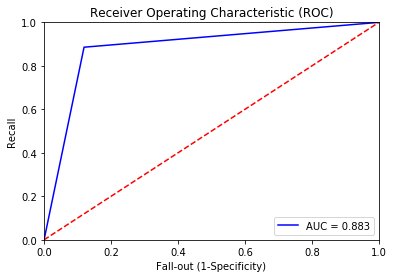

AUC score: 0.8831556503198295


In [30]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#### Print Confusion Matrix

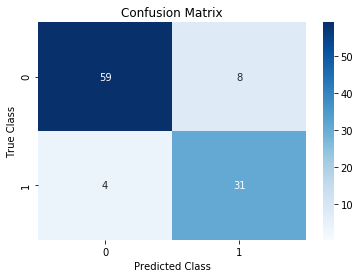

In [31]:
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Train model on entire data

In [32]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [33]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.29782
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.330124
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.332062
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 0.351975
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.314061


## Create submission file

In [34]:
submit_df = pd.DataFrame(y_pred, columns=['1','2'])
submit_df.head()

,1,2
0,0.972722,0.027278
1,0.189669,0.810331
2,0.972722,0.027278
3,0.972722,0.027278
4,0.600394,0.399606


In [35]:
submit_df.to_excel("Predictions/predictions_v9.xlsx", index=False)